In [1]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Conv2D, Flatten, Dense, Activation, Add, BatchNormalization, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [2]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    mapping = data["mapping"]
    return X, y, mapping

In [3]:
json_path = "../input/data-json/data_10.json"
X, y, mapping = load_data(json_path)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [6]:
X_train = np.expand_dims(X_train, -1)
X_test = X_test[..., np.newaxis]
X_val = np.expand_dims(X_val, -1)

In [15]:
X_train.shape

(6740, 130, 13, 1)

In [7]:
class Residual(tf.keras.Model):
    def __init__(self, num_filters, use_1x1=False, strides=1):
        
        super(Residual, self).__init__()
        self.conv1 = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')
        self.batchnorm = BatchNormalization()
        self.activation = Activation('relu')
        self.conv2 = Conv2D(num_filters, kernel_size=3, strides=1, padding='same')
        if use_1x1:
            self.conv3 = Conv2D(num_filters, kernel_size=1, strides=strides, padding='valid')
        else: 
            self.conv3 = None

    def call(self, x):
        shortcut = x
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batchnorm(x)
        if self.conv3:
            shortcut = self.conv3(shortcut)
        return self.activation(x + shortcut)

In [17]:
def Resnet(input_shape):
    input_img = Input(shape=input_shape) 
    x = input_img


    x = Residual(128, use_1x1=True, strides=2)(x)
    x = Residual(128)(x)
    
    x = Residual(512, use_1x1=True, strides=2)(x)
    x = Residual(512)(x)
    
    x = Residual(1024, use_1x1=True, strides=2)(x)
    x = Residual(1024)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(10, activation='softmax')(x)


    model = Model(inputs=input_img, outputs=x, name='Resnet18')
    return model

In [18]:
model = Resnet(X_train[0].shape)
optimizer = K.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "Resnet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 130, 13, 1)]      0         
_________________________________________________________________
residual_8 (Residual)        (None, 65, 7, 128)        149632    
_________________________________________________________________
residual_9 (Residual)        (None, 65, 7, 128)        295680    
_________________________________________________________________
residual_10 (Residual)       (None, 33, 4, 512)        3018240   
_________________________________________________________________
residual_11 (Residual)       (None, 33, 4, 512)        4721664   
_________________________________________________________________
residual_12 (Residual)       (None, 17, 2, 1024)       14687232  
_________________________________________________________________
residual_13 (Residual)       (None, 17, 2, 1024)       188

In [19]:
def lrdecay(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.5e-3
    elif epoch > 20:
        lr *= 1e-3
    elif epoch > 30:
        lr *= 1e-2
    elif epoch > 35:
        lr *= 1e-1
    return lr
lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay)

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=40, callbacks=[lrdecay])

Epoch 1/40
106/106 [==============================] - 15s 125ms/step - loss: 2.2875 - accuracy: 0.2178 - val_loss: 2.1834 - val_accuracy: 0.1562
Epoch 2/40
106/106 [==============================] - 12s 118ms/step - loss: 2.0196 - accuracy: 0.2504 - val_loss: 2.1529 - val_accuracy: 0.1696
Epoch 3/40
106/106 [==============================] - 13s 118ms/step - loss: 1.8163 - accuracy: 0.3337 - val_loss: 1.8767 - val_accuracy: 0.2684
Epoch 4/40
106/106 [==============================] - 13s 118ms/step - loss: 1.6156 - accuracy: 0.4036 - val_loss: 1.9006 - val_accuracy: 0.2764
Epoch 5/40
106/106 [==============================] - 12s 118ms/step - loss: 1.4827 - accuracy: 0.4488 - val_loss: 1.9447 - val_accuracy: 0.2764
Epoch 6/40
106/106 [==============================] - 12s 118ms/step - loss: 1.3318 - accuracy: 0.5096 - val_loss: 2.1197 - val_accuracy: 0.2937
Epoch 7/40
106/106 [==============================] - 12s 118ms/step - loss: 1.2402 - accuracy: 0.5469 - val_loss: 1.7570 - val_ac

In [21]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("Test loss : {}, Test accuracy: {}".format(test_loss, test_acc))

79/79 [==============================] - 2s 24ms/step - loss: 1.7228 - accuracy: 0.3712
Test loss : 1.7228330373764038, Test accuracy: 0.37124550342559814


In [22]:
def plot_history(history): 
    fig, axs = plt.subplots(2, figsize=(10, 10))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="valid accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train loss")
    axs[1].plot(history.history["val_loss"], label="valid loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Valid evaluation")

    plt.show()

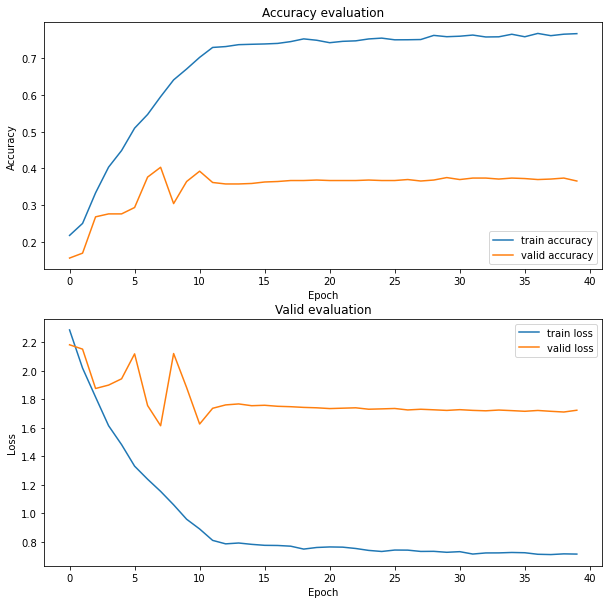

In [23]:
plot_history(history)

Bad reslut!